<a href="https://www.kaggle.com/code/yichaoliu/001-titanic-survival?scriptVersionId=99252150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
data = pd.read_csv('/kaggle/input/titanic/train.csv',index_col = 'PassengerId')
data_test = pd.read_csv('/kaggle/input/titanic/test.csv',index_col = 'PassengerId')

In [3]:
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Data Cleaning & Feature Engineering

In [4]:
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
data_test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

## Drop High Cardinal Categorical Features

In [6]:
data['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [7]:
data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [8]:
data.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
data_test.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

## Encode Categorical Features

In [9]:
data.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Female passengers have more chance to survive.

In [10]:
data['Male'] = (data['Sex']=='male').astype(int)

data_test['Male'] = (data_test['Sex']=='male').astype(int)

In [11]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
data['Embarked'].fillna('S',inplace = True)

In [13]:
data.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [14]:
data.groupby('Embarked')['Fare'].mean()

Embarked
C    59.954144
Q    13.276030
S    27.243651
Name: Fare, dtype: float64

In [15]:
data['log_Fare'] = data['Fare'].apply(lambda x: np.log(x+1))

data_test['Fare'].fillna(data_test['Fare'].median(),inplace = True)
data_test['log_Fare'] = data_test['Fare'].apply(lambda x: np.log(x+1))

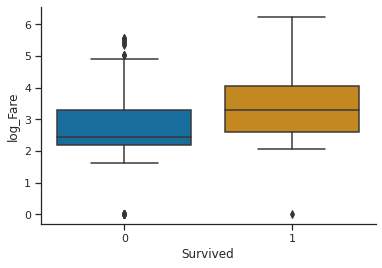

In [16]:
sns.set_theme(style = 'ticks',palette = 'colorblind')
sns.boxplot(data = data, x='Survived',y='log_Fare')
sns.despine()
plt.show()

Where people embarked also affects the chance of survival, but that's probably because the fares are different, higher price leads to higher chance of survival.

In [17]:
data['Embarked_S'] = (data['Embarked']=='S').astype(int)
data['Embarked_C'] = (data['Embarked']=='C').astype(int)

data_test['Embarked_S'] = (data_test['Embarked']=='S').astype(int)
data_test['Embarked_C'] = (data_test['Embarked']=='C').astype(int)

In [18]:
data.groupby('SibSp')['Survived'].agg(['mean','count'])

,mean,count
SibSp,,
0,0.345395,608
1,0.535885,209
2,0.464286,28
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


In [19]:
data.groupby('Parch')['Survived'].agg(['mean','count'])

,mean,count
Parch,,
0,0.343658,678
1,0.550847,118
2,0.500000,80
3,0.600000,5
4,0.000000,4
5,0.200000,5
6,0.000000,1


In [20]:
feature_cols = ['Age','Male','Pclass','SibSp', 'Parch', 'log_Fare', 'Embarked_S', 'Embarked_C']
X = data.loc[:,feature_cols]
y = data['Survived']
X_test = data_test.loc[:,feature_cols]

## Handle Missing Values

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=20, random_state=0)

imp_cols = imp.fit_transform(X)
X['Age'] = imp_cols[:,0]

imp_cols_test = imp.fit_transform(X_test)
X_test['Age'] = imp_cols_test[:,0]

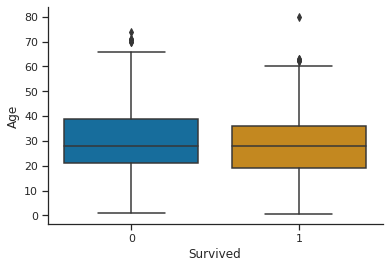

In [22]:
sns.set_theme(style = 'ticks',palette = 'colorblind')
sns.boxplot(data = data, x='Survived',y='Age')
sns.despine()
plt.show()

Age does not affect the chance of survival significantly.

In [23]:
X.head(3)

,Age,Male,Pclass,SibSp,Parch,log_Fare,Embarked_S,Embarked_C
PassengerId,,,,,,,,
1,22.0,1,3,1,0,2.110213,1,0
2,38.0,0,1,1,0,4.280593,0,1
3,26.0,0,3,0,0,2.188856,1,0


In [24]:
X_test.head(3)

,Age,Male,Pclass,SibSp,Parch,log_Fare,Embarked_S,Embarked_C
PassengerId,,,,,,,,
892,34.5,1,3,0,0,2.178064,0,0
893,47.0,0,3,1,0,2.079442,1,0
894,62.0,1,2,0,0,2.369075,0,0


# Modeling

In [25]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,XGBRFClassifier

models = []
models.append(('LR', LogisticRegression(solver = 'liblinear',random_state=0)))
models.append(('SVM', SVC(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0)))
models.append(('XGB', XGBClassifier(random_state=0)))
models.append(('XGBRF', XGBRFClassifier(random_state=0)))


LR: 0.795755 (0.032728)
SVM: 0.704869 (0.051457)
RFC: 0.808165 (0.041327)
XGB: 0.803608 (0.037921)
XGBRF: 0.831723 (0.037812)


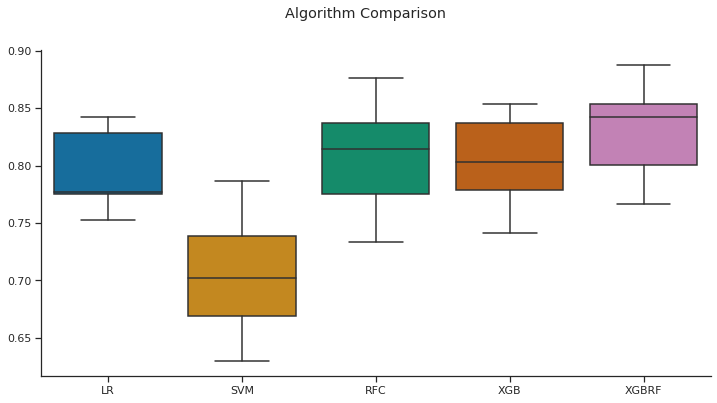

In [26]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize = (12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names)
sns.despine()
plt.show()

## XGBoost Random Forest Classifier

In [27]:
from sklearn.model_selection import GridSearchCV

xgbrfc = XGBRFClassifier(random_state = 0)
params = [{'n_estimators': [120,130,140,150],
           'subsample':[0.9,0.8,0.7,0.6],
           'colsample_bynode': [0.5,0.75,1]}]

gs_xgb = GridSearchCV(xgbrfc,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5,
                      verbose = 1)
gs_xgb.fit(X, y)
print('Best Params: ',gs_xgb.best_params_)
print('Best Scores: ',gs_xgb.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params:  {'colsample_bynode': 1, 'n_estimators': 140, 'subsample': 0.7}
Best Scores:  0.8361747536250078


# Prediction

In [28]:
xgbrfc = XGBRFClassifier(n_estimators = 140,
                         subsample = 0.7,
                         colsample_bynode = 1,
                         random_state = 0).fit(X, y)

y_test = xgbrfc.predict(X_test)

In [29]:
submission = pd.DataFrame(y_test,index = X_test.index,columns=['Survived']).reset_index()
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [30]:
submission.to_csv('submission.csv',index = False)